In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV, KFold
from keras.layers import Dense, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc


# Load the dataset
data = pd.read_csv('household_power_consumption.txt', sep=';', 
                   parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True, 
                   low_memory=False, na_values=['nan', '?'])

data.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [109]:
data.tail()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2075258,2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [110]:
# Print summary information about the data

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
None


In [111]:
df = data.isnull().sum()
print(df)  # Print the number of missing values per column

Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [112]:
# Fill missing values using forward-fill method
data.fillna(method='ffill', inplace=True)

# Verify that there are no more missing values
missing_values_after_filling = data.isnull().sum()
missing_values_after_filling


Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [113]:
data

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [114]:
# Convert relevant columns to numeric

cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


data[cols_to_convert].head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [115]:
# Drop rows with missing values
data.dropna(inplace=True)
data.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [116]:
# Set the datetime as the index
data.set_index('Datetime', inplace=True)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [117]:
# Aggregate data to daily consumption
daily_data = data.resample('D').sum()

daily_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0


In [118]:
# Drop rows with missing values after resampling
daily_data.dropna(inplace=True)

daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


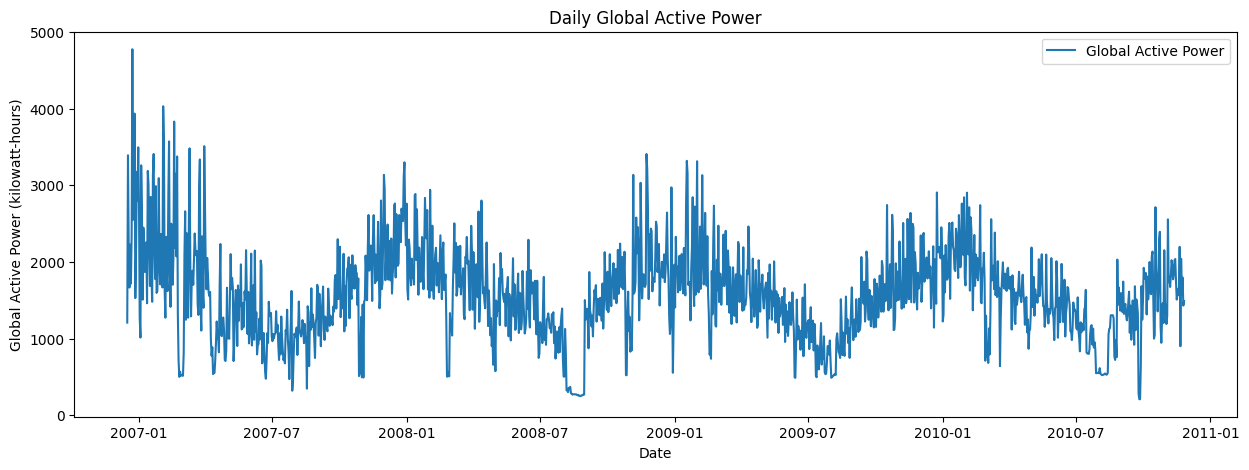

In [119]:
# Plot the daily global active power
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatt-hours)')
plt.title('Daily Global Active Power')
plt.legend()
plt.show()

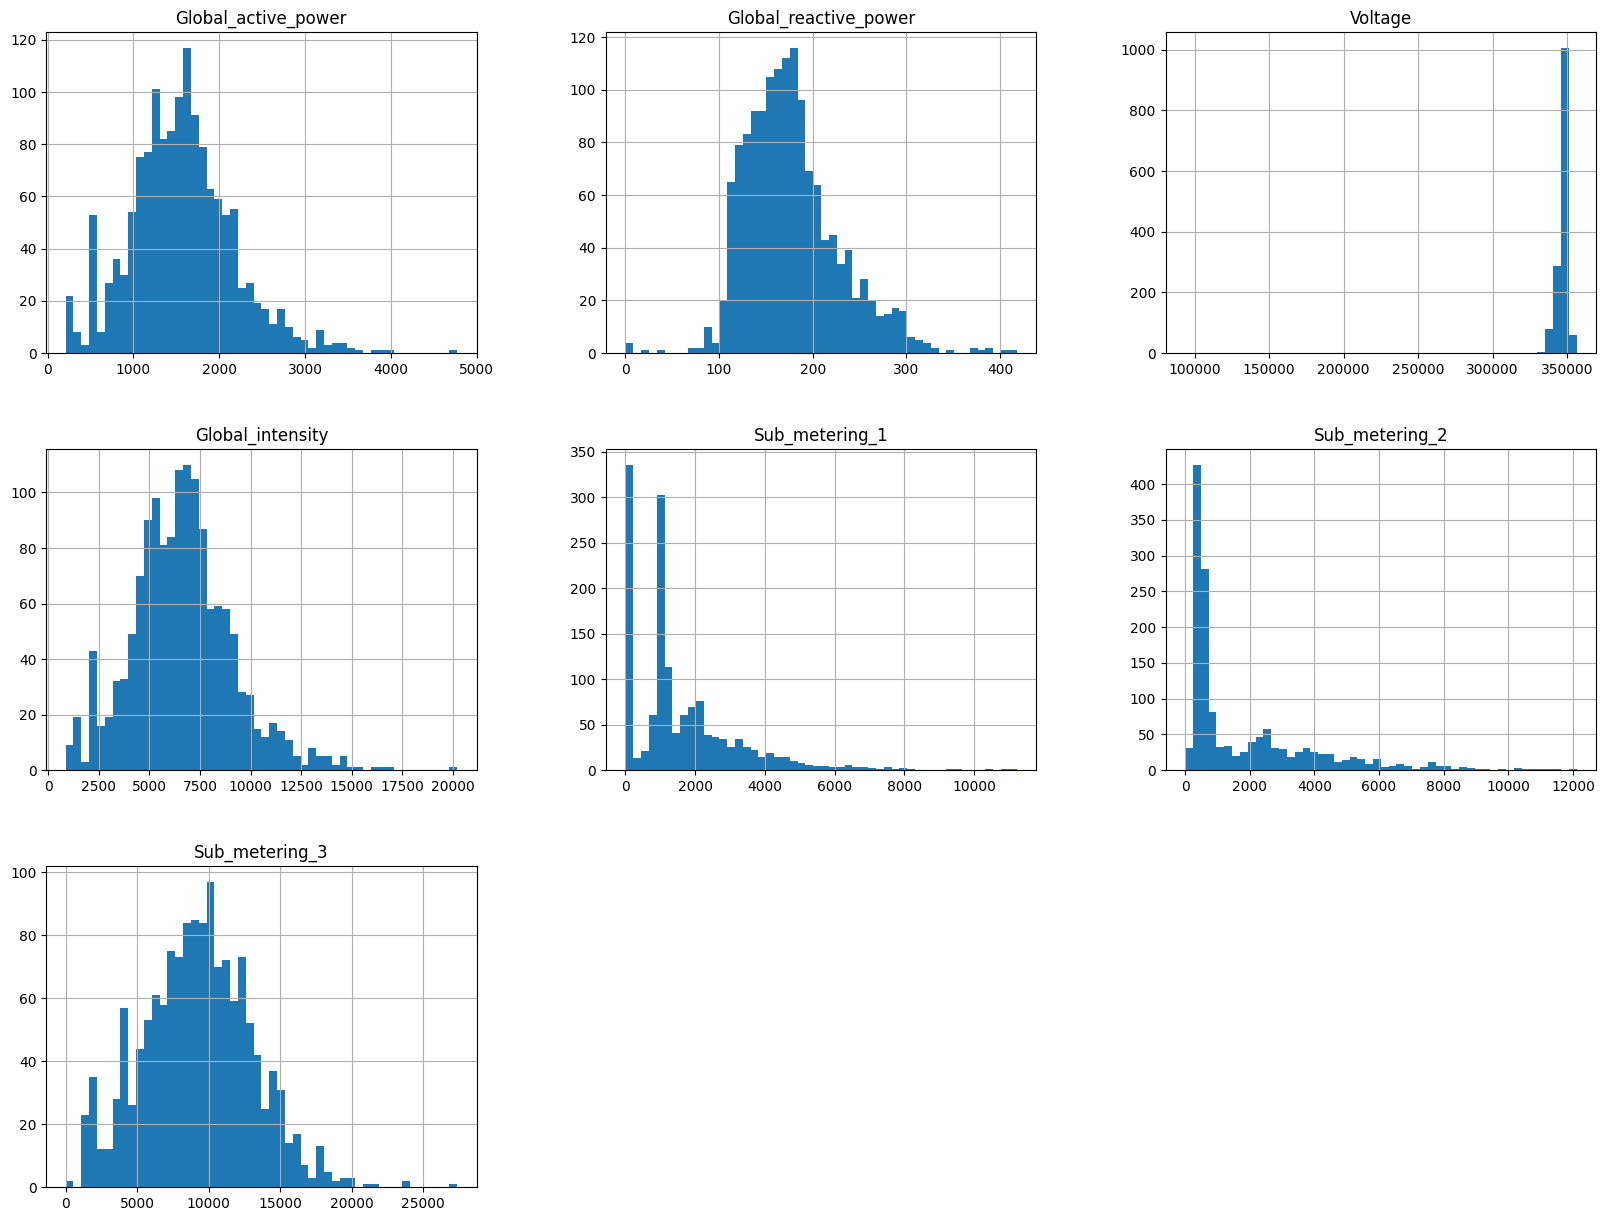

In [120]:
# plot the histogram of the features
daily_data.hist(bins=50, figsize=(20, 15))
plt.show()


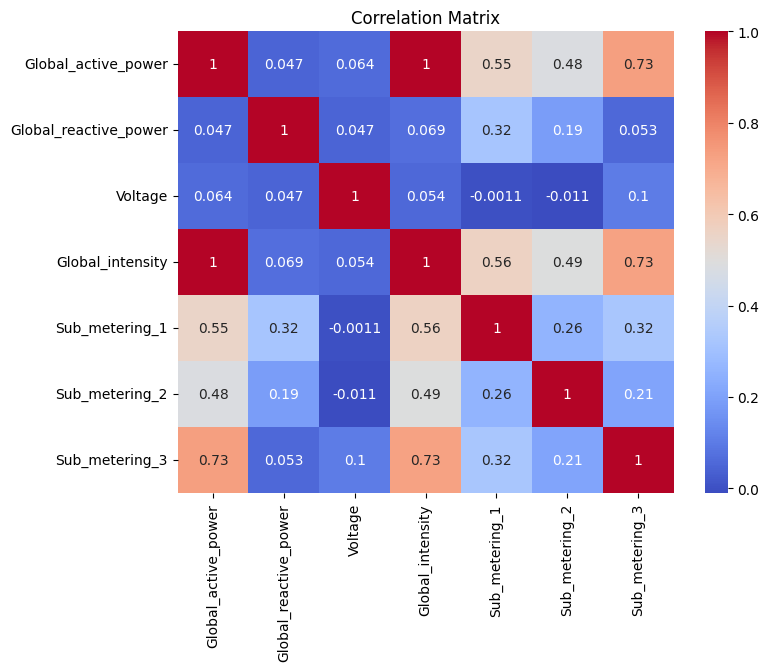

In [121]:
corr_matrix = daily_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

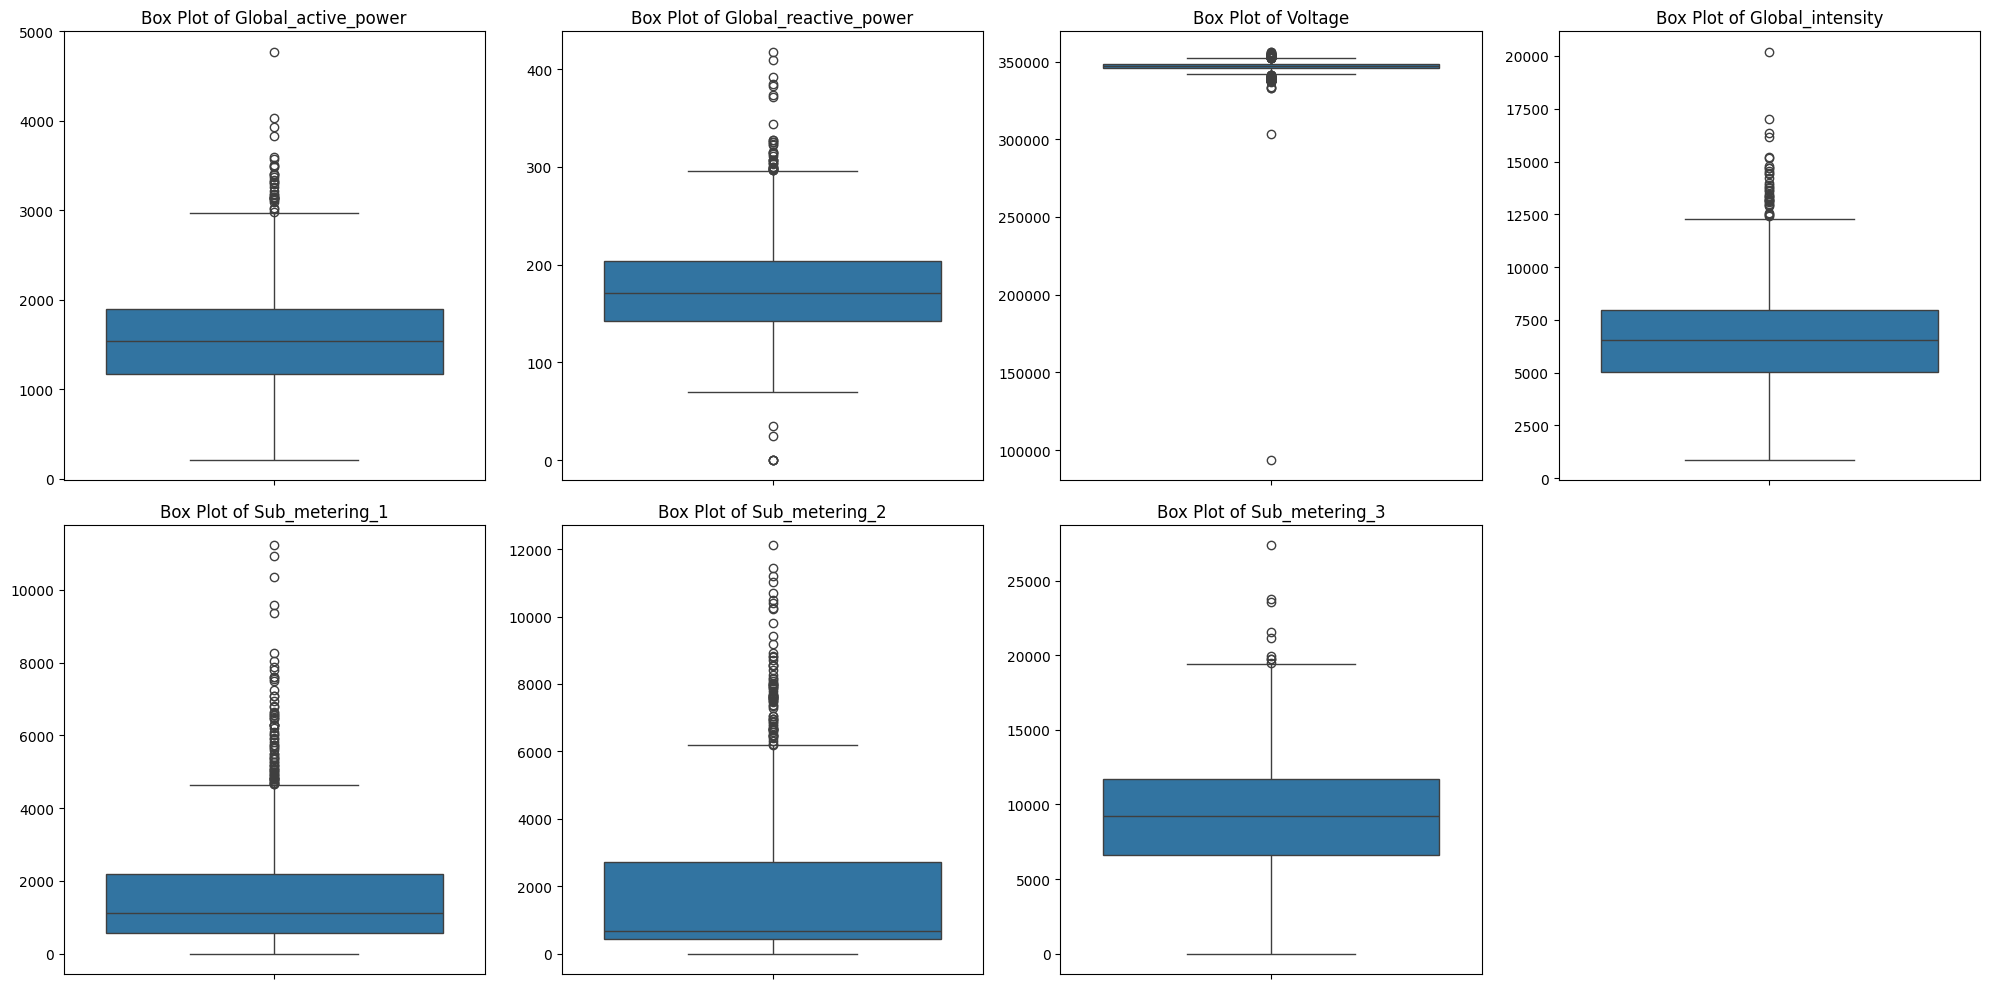

In [122]:
# List of columns to plot
columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
           'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Number of subplots per row
subplots_per_row = 4

# Calculate number of rows needed
num_rows = (len(columns) + subplots_per_row - 1) // subplots_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(20, 5 * num_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Generate box plots for each column
for i, column in enumerate(columns):
    sns.boxplot(data=daily_data[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Available features for decomposition:
Global_active_power
Global_reactive_power
Voltage
Global_intensity
Sub_metering_1
Sub_metering_2
Sub_metering_3


Enter the feature you want to decompose:  Global_active_power


<Figure size 1500x800 with 0 Axes>

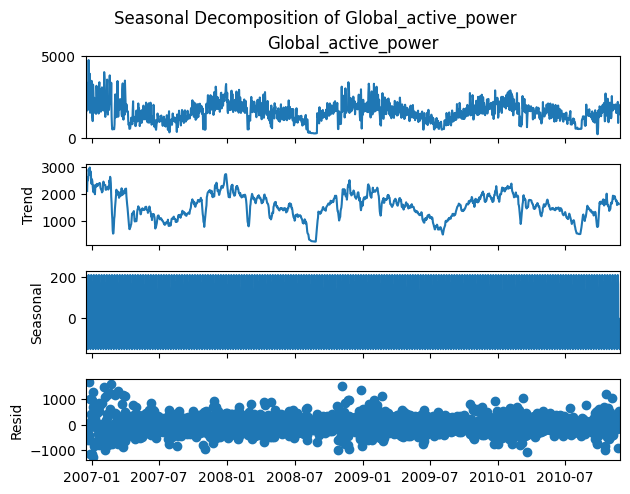

In [123]:


# List of available features
features_to_decompose = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                         'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Prompt user to select a feature to decompose
print("Available features for decomposition:")
for feature in features_to_decompose:
    print(feature)

selected_feature = input("Enter the feature you want to decompose: ")

# Validate user input
if selected_feature in features_to_decompose:
    result = seasonal_decompose(daily_data[selected_feature], model='additive')
    plt.figure(figsize=(15, 8))
    result.plot()
    plt.suptitle(f'Seasonal Decomposition of {selected_feature}', fontsize=12, y = 1.02)
    plt.show()
else:
    print(f"'{selected_feature}' is not a valid feature. Please choose from the available features.")


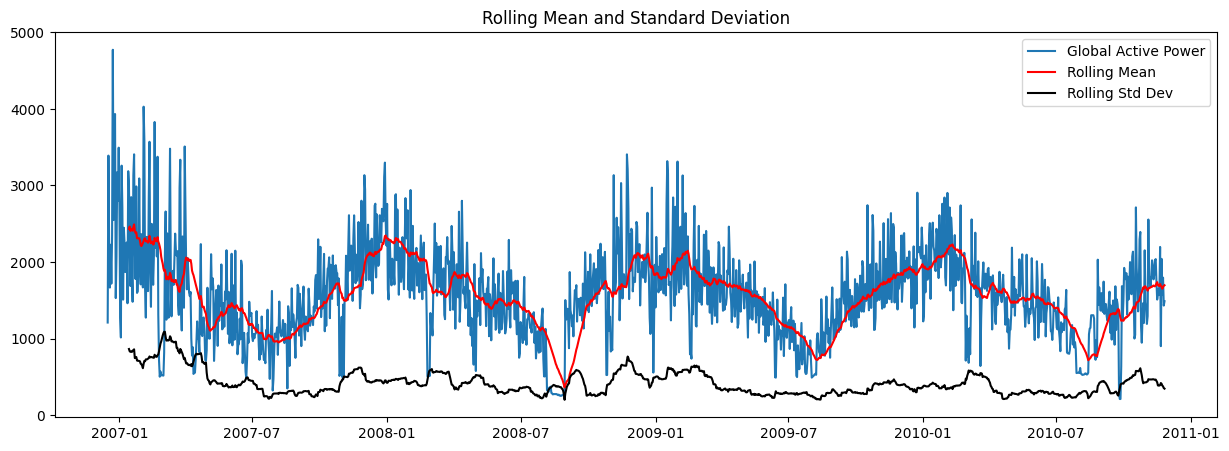

In [124]:
rolling_mean = daily_data['Global_active_power'].rolling(window=30).mean()
rolling_std = daily_data['Global_active_power'].rolling(window=30).std()

plt.figure(figsize=(15, 5))
plt.plot(daily_data['Global_active_power'], label='Global Active Power')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='black')
plt.legend()
plt.title('Rolling Mean and Standard Deviation')
plt.show()


#### Statistical Anomaly Dectection Method

In [125]:
# Calculate mean and standard deviation
mean = daily_data['Global_active_power'].mean()
std = daily_data['Global_active_power'].std()

# Define thresholds
threshold_upper = mean + 3 * std
threshold_lower = mean - 3 * std

# Identify anomalies using statistical methods
anomalies_statistical = daily_data[(daily_data['Global_active_power'] > threshold_upper) | 
                                   (daily_data['Global_active_power'] < threshold_lower)]

print("Statistical Anomalies:")
anomalies_statistical

Statistical Anomalies:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-23,4773.386,221.470,345795.95,20200.4,2669.0,425.0,14726.0
2006-12-26,3934.110,165.102,347940.63,16341.0,1086.0,2533.0,14979.0
2006-12-31,3494.196,150.852,345451.07,14687.4,0.0,347.0,6502.0
2007-01-21,3407.262,229.736,344114.09,14674.6,10346.0,5567.0,11599.0
2007-02-03,4029.722,245.824,344030.68,17015.0,4746.0,4573.0,17834.0
2007-02-04,3595.940,186.494,345072.00,15214.2,3391.0,4597.0,14472.0
2007-02-11,3571.228,204.314,344888.85,15158.6,2430.0,4765.0,13114.0
2007-02-18,3829.762,255.522,344405.96,16184.0,6107.0,8003.0,13129.0


In [126]:
# Count the number of anomalies detected
num_anomalies = len(anomalies_statistical)

print("Number of Statistical Anomalies Detected:", num_anomalies)

Number of Statistical Anomalies Detected: 13


In [127]:
# Normalize the data for machine learning models
scaler = StandardScaler()
normalized_data = scaler.fit_transform(daily_data)

### Isolation Forest Anomaly Detection Method

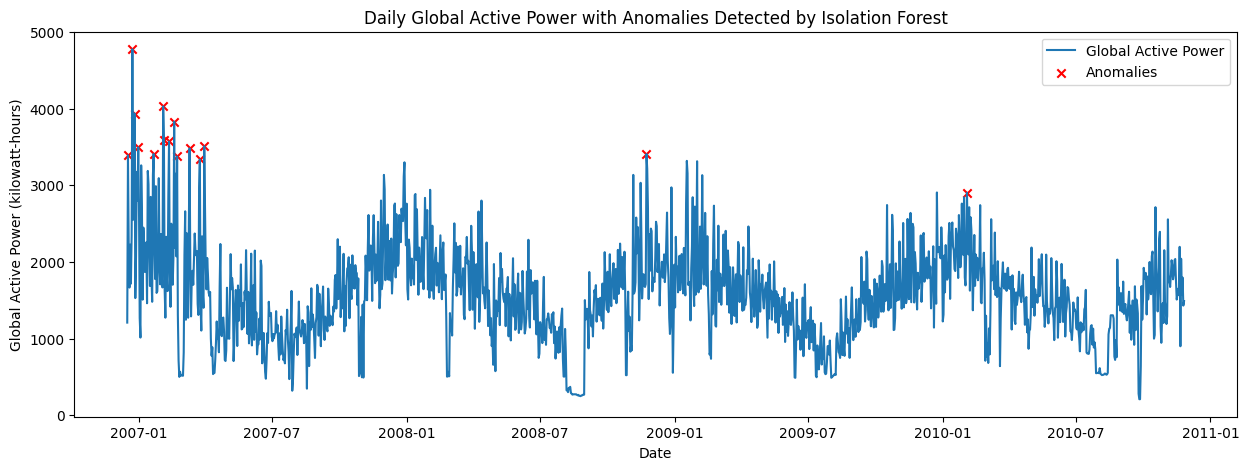

In [128]:
# Train the Isolation Forest model
isolation_forest = IsolationForest(n_estimators = 50, max_samples = 'auto', max_features=1.0, contamination=0.01, random_state=42)
selected_feature_indices = [0, 3, 6]
pred_data = normalized_data[:, selected_feature_indices]
anomaly_labels = isolation_forest.fit_predict(pred_data)

# Add anomaly labels to the data
daily_data['Anomaly_IsolationForest'] = anomaly_labels

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Global Active Power')
plt.scatter(daily_data[daily_data['Anomaly_IsolationForest'] == -1].index, 
            daily_data[daily_data['Anomaly_IsolationForest'] == -1]['Global_active_power'], 
            color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatt-hours)')
plt.title('Daily Global Active Power with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()

In [129]:
# Recalculate and print the number of anomalies and normal instances
anomaly_counts = daily_data['Anomaly_IsolationForest'].value_counts()
num_normals_isolation_forest = anomaly_counts.get(1, 0)
num_anomalies_isolation_forest = anomaly_counts.get(-1, 0)

print(f"Number of normal instances detected by Isolation Forest: {num_normals_isolation_forest}")
print(f"Number of anomalies detected by Isolation Forest: {num_anomalies_isolation_forest}")


Number of normal instances detected by Isolation Forest: 1427
Number of anomalies detected by Isolation Forest: 15


In [130]:
# Create true labels: 1 for normal, -1 for anomaly
true_labels = np.ones(daily_data.shape[0])
true_labels[daily_data.index.isin(anomalies_statistical.index)] = -1

# Get the predicted labels from Isolation Forest
predicted_labels = daily_data['Anomaly_IsolationForest']

# Calculate F1 Score
f1_isolation_forest = f1_score(true_labels, predicted_labels, pos_label=-1)

# Calculate Accuracy
accuracy_isolation_forest = accuracy_score(true_labels, predicted_labels)

# Calculate Precision
precision_isolation_forest = precision_score(true_labels, predicted_labels, pos_label=-1)

# Calculate Recall
recall_isolation_forest = recall_score(true_labels, predicted_labels, pos_label=-1)

# Print the metrics
print(f"Isolation Forest F1 Score: {f1_isolation_forest}")
print(f"Isolation Forest Accuracy: {accuracy_isolation_forest}")
print(f"Isolation Forest Precision: {precision_isolation_forest}")
print(f"Isolation Forest Recall: {recall_isolation_forest}")


Isolation Forest F1 Score: 0.9285714285714286
Isolation Forest Accuracy: 0.9986130374479889
Isolation Forest Precision: 0.8666666666666667
Isolation Forest Recall: 1.0


Confusion Matrix:
[[  13    0]
 [   2 1427]]
ROC AUC Score: 0.999300209937019


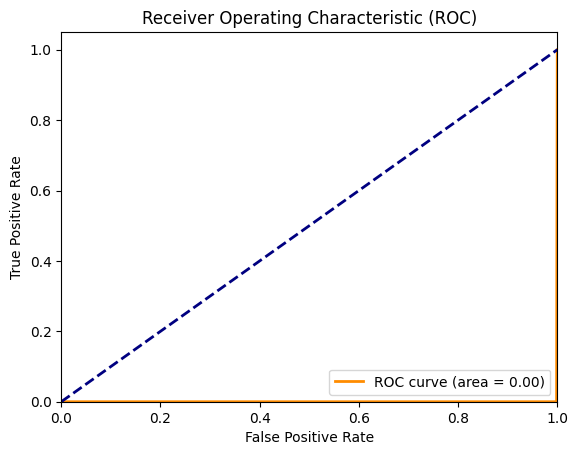

In [131]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[-1, 1])

# ROC AUC Score
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print ROC AUC Score
print(f"ROC AUC Score: {roc_auc}")

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels, pos_label=-1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [132]:

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.6, 0.8],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1.0, 0.5, 0.75]
}

# Initialize the model
isolation_forest = IsolationForest(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=isolation_forest, param_distributions=param_dist, 
                                   scoring='f1', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(pred_data, true_labels)

# Get the best parameters
best_params = random_search.best_params_

print(f"Best parameters: {best_params}")

# Train the Isolation Forest with the best parameters
best_isolation_forest = IsolationForest(**best_params, random_state=42)
best_isolation_forest.fit(pred_data)

# Predict anomalies
best_anomaly_labels = best_isolation_forest.predict(pred_data)

# Calculate F1 Score
f1_best_isolation_forest = f1_score(true_labels, best_anomaly_labels, pos_label=-1)

print(f"Best Isolation Forest F1 Score: {f1_best_isolation_forest}")


Best parameters: {'n_estimators': 50, 'max_samples': 'auto', 'max_features': 1.0, 'contamination': 0.01}
Best Isolation Forest F1 Score: 0.9285714285714286


## Autoencoder Model

In [133]:

# Normalize the data for Autoencoder
scaler_autoencoder = MinMaxScaler()
normalized_data_autoencoder = scaler_autoencoder.fit_transform(daily_data)

# Define the Autoencoder model 
input_dim_autoencoder = normalized_data_autoencoder.shape[1]
encoding_dim_autoencoder = 14  # You can choose a different number

autoencoder = Sequential([
    Dense(encoding_dim_autoencoder, input_shape=(input_dim_autoencoder,), activation='relu'),
    BatchNormalization(),
    Dense(encoding_dim_autoencoder // 2, activation='relu'),
    BatchNormalization(),
    Dense(encoding_dim_autoencoder // 4, activation='relu'),
    BatchNormalization(),
    Dense(encoding_dim_autoencoder // 2, activation='relu'),
    BatchNormalization(),
    Dense(input_dim_autoencoder, activation='relu')
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Setting up early stopping
early_stopping_autoencoder = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_autoencoder = autoencoder.fit(normalized_data_autoencoder, normalized_data_autoencoder, 
                                      epochs=100, batch_size=32, validation_split=0.2, verbose=1, 
                                      callbacks=[early_stopping_autoencoder])

Epoch 1/100
37/37 [==============================] - 6s 32ms/step - loss: 0.3622 - val_loss: 0.2799
Epoch 2/100
37/37 [==============================] - 0s 10ms/step - loss: 0.2546 - val_loss: 0.2657
Epoch 3/100
37/37 [==============================] - 0s 12ms/step - loss: 0.2036 - val_loss: 0.2570
Epoch 4/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1732 - val_loss: 0.2123
Epoch 5/100
37/37 [==============================] - 0s 8ms/step - loss: 0.1535 - val_loss: 0.1664
Epoch 6/100
37/37 [==============================] - 0s 9ms/step - loss: 0.1375 - val_loss: 0.1194
Epoch 7/100
37/37 [==============================] - 0s 7ms/step - loss: 0.1243 - val_loss: 0.0866
Epoch 8/100
37/37 [==============================] - 0s 8ms/step - loss: 0.1036 - val_loss: 0.0618
Epoch 9/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0827 - val_loss: 0.0550
Epoch 10/100
37/37 [==============================] - 0s 9ms/step - loss: 0.0698 - val_loss: 0.0464
Epoc

In [134]:
# Predict the reconstructed data
reconstructed_data_autoencoder = autoencoder.predict(normalized_data_autoencoder)

# Calculate the reconstruction error
reconstruction_error_autoencoder = np.mean(np.power(normalized_data_autoencoder - reconstructed_data_autoencoder, 2), axis=1)

# Define a threshold for anomalies (e.g., 95th percentile)
threshold_autoencoder = np.percentile(reconstruction_error_autoencoder, 95)
anomalies_autoencoder = daily_data[reconstruction_error_autoencoder > threshold_autoencoder]

# Add anomaly labels to the data
daily_data['Anomaly_Autoencoder'] = reconstruction_error_autoencoder > threshold_autoencoder


46/46 [==============================] - 1s 5ms/step


In [135]:
# Print out the anomalies detected by Autoencoder
autoencoder_anomalies = daily_data[daily_data['Anomaly_Autoencoder']]
print("Anomalies Detected by Autoencoder:")
autoencoder_anomalies

Anomalies Detected by Autoencoder:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Anomaly_IsolationForest,Anomaly_Autoencoder
Datetime,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,1,True
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,-1,True
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,1,True
2006-12-23,4773.386,221.470,345795.95,20200.4,2669.0,425.0,14726.0,-1,True
2006-12-26,3934.110,165.102,347940.63,16341.0,1086.0,2533.0,14979.0,-1,True
...,...,...,...,...,...,...,...,...,...
2010-08-27,2030.650,304.318,346837.62,8631.4,930.0,7583.0,12707.0,1,True
2010-09-26,210.240,69.120,349056.00,864.0,0.0,0.0,1440.0,1,True
2010-09-27,210.240,69.120,349056.00,864.0,0.0,0.0,1440.0,1,True


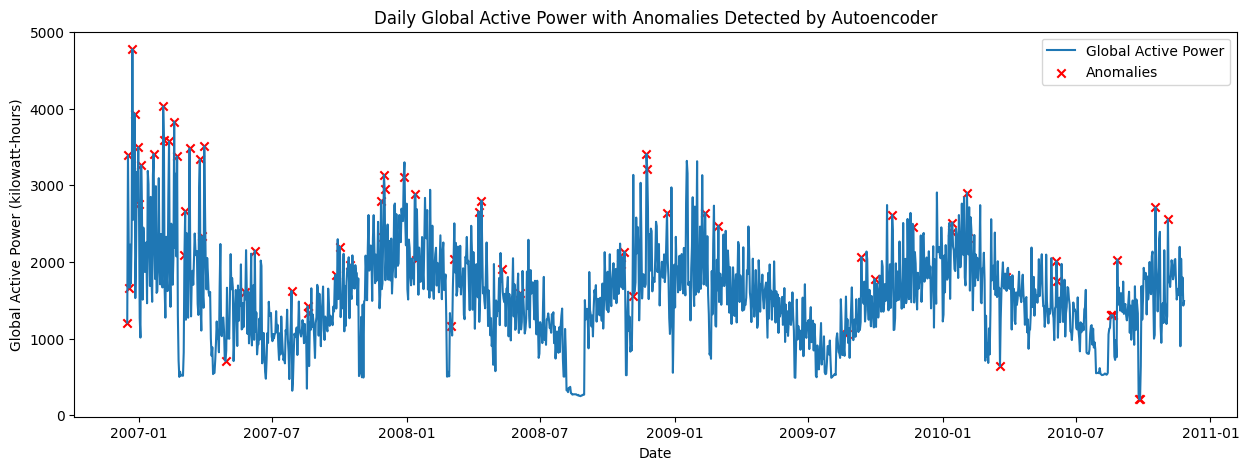

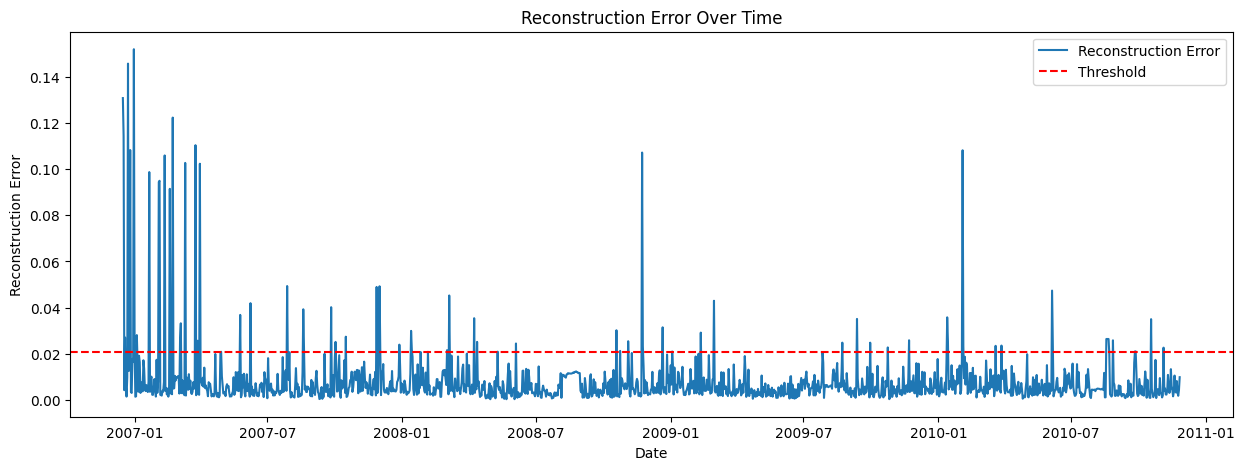

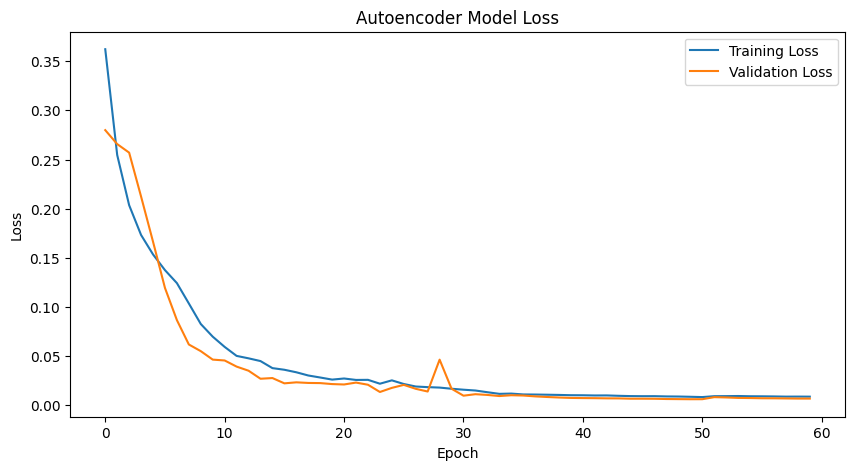

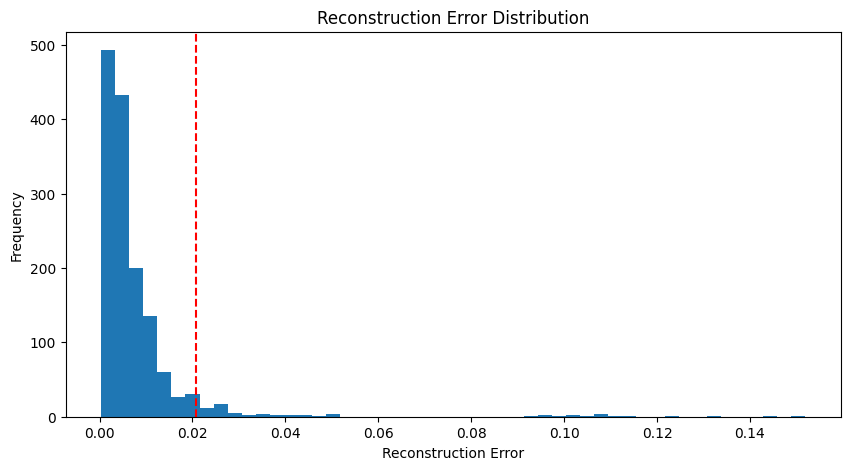

In [136]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Global Active Power')
plt.scatter(daily_data[daily_data['Anomaly_Autoencoder']].index, 
            daily_data[daily_data['Anomaly_Autoencoder']]['Global_active_power'], 
            color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatt-hours)')
plt.title('Daily Global Active Power with Anomalies Detected by Autoencoder')
plt.legend()
plt.show()

# Plot reconstruction error
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, reconstruction_error_autoencoder, label='Reconstruction Error')
plt.axhline(y=threshold_autoencoder, color='r', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot reconstruction error distribution
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error_autoencoder, bins=50)
plt.axvline(threshold_autoencoder, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.show()

In [137]:
from sklearn.metrics import mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(normalized_data_autoencoder, reconstructed_data_autoencoder)
print(f"Mean Squared Error (MSE): {mse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(normalized_data_autoencoder, reconstructed_data_autoencoder)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.0077725940817107275
Mean Absolute Error (MAE): 0.060234404053870025


## LSTM Model

In [138]:
# Split the data into training and test sets
train_size = int(len(daily_data) * 0.7)
test_size = len(daily_data) - train_size

train_data = daily_data[:train_size]
test_data = daily_data[train_size:]

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

# Reshape for LSTM
X_train = np.reshape(train_data_normalized, (train_data_normalized.shape[0], train_data_normalized.shape[1], 1))
X_test = np.reshape(test_data_normalized, (test_data_normalized.shape[0], test_data_normalized.shape[1], 1))

# Define the LSTM model with increased layers
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(train_data_normalized.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Setting up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_lstm = model.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)    


# Predict the reconstructed data for test set
X_test_pred = model.predict(X_test)

# Reshape X_test_pred to match the shape of X_test
X_test_pred = np.reshape(X_test_pred, (X_test_pred.shape[0], X_test_pred.shape[1], 1))


# Calculate the reconstruction error for test set
test_reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Define a threshold for anomalies (e.g., 95th percentile of training reconstruction error)
threshold_test = np.percentile(test_reconstruction_error, 94.5)
anomalies_test_autoencoder = test_reconstruction_error > threshold_test

# Ensure that the anomalies_test_autoencoder is a 1D array
anomalies_test_autoencoder = anomalies_test_autoencoder.ravel()

# Add a new column to the daily_data to flag anomalies detected by LSTM
daily_data['Anomaly_LSTM'] = False  # Initialize with False

# Assign anomaly flags to the corresponding test data portion using .loc to avoid the warning
daily_data.loc[daily_data.index[train_size:], 'Anomaly_LSTM'] = anomalies_test_autoencoder
    

Epoch 1/100
26/26 [==============================] - 16s 97ms/step - loss: 0.2308 - val_loss: 0.1077
Epoch 2/100
26/26 [==============================] - 1s 42ms/step - loss: 0.0605 - val_loss: 0.0217
Epoch 3/100
26/26 [==============================] - 1s 39ms/step - loss: 0.0263 - val_loss: 0.0142
Epoch 4/100
26/26 [==============================] - 1s 38ms/step - loss: 0.0240 - val_loss: 0.0146
Epoch 5/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0231 - val_loss: 0.0134
Epoch 6/100
26/26 [==============================] - 1s 33ms/step - loss: 0.0223 - val_loss: 0.0138
Epoch 7/100
26/26 [==============================] - 1s 35ms/step - loss: 0.0207 - val_loss: 0.0117
Epoch 8/100
26/26 [==============================] - 2s 61ms/step - loss: 0.0177 - val_loss: 0.0106
Epoch 9/100
26/26 [==============================] - 2s 58ms/step - loss: 0.0159 - val_loss: 0.0102
Epoch 10/100
26/26 [==============================] - 1s 50ms/step - loss: 0.0154 - val_loss: 0.009

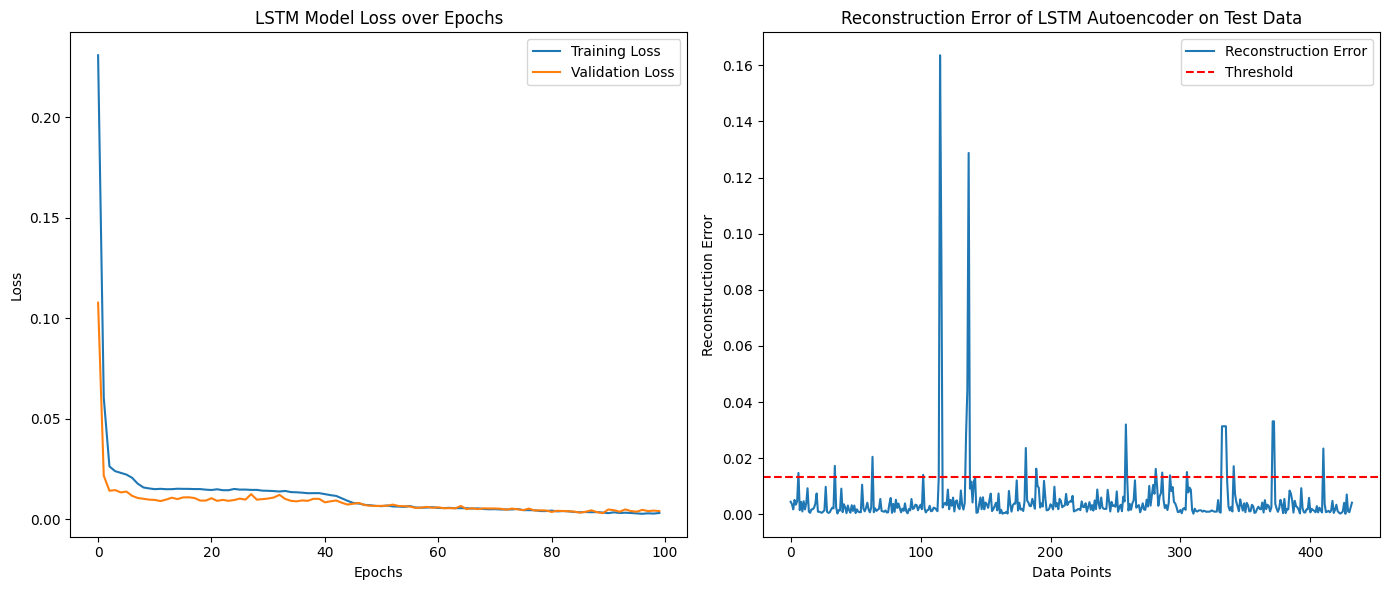

In [139]:
# Plot the training loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the reconstruction error
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(test_reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold_test, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error of LSTM Autoencoder on Test Data')
plt.xlabel('Data Points')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.tight_layout()
plt.show()


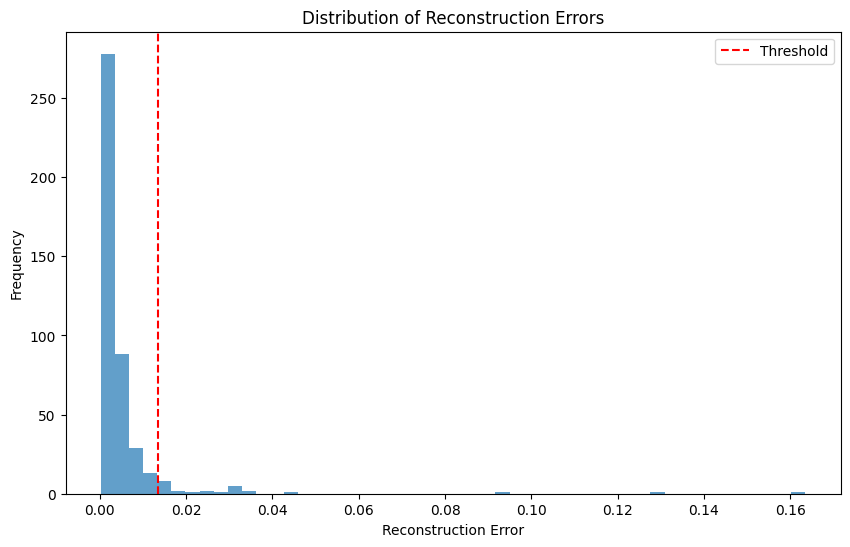

In [140]:

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(test_reconstruction_error, bins=50, alpha=0.7)
plt.axvline(threshold_test, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


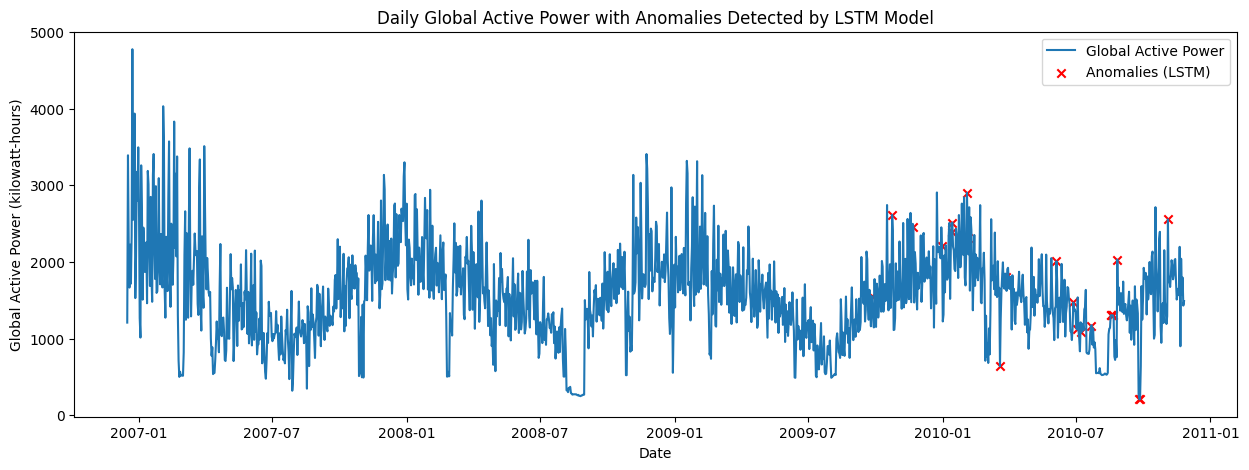

In [141]:

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Global Active Power')

# Scatter plot for LSTM detected anomalies
plt.scatter(daily_data[daily_data['Anomaly_LSTM']].index, 
            daily_data[daily_data['Anomaly_LSTM']]['Global_active_power'], 
            color='red', label='Anomalies (LSTM)', marker='x')

plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatt-hours)')
plt.title('Daily Global Active Power with Anomalies Detected by LSTM Model')
plt.legend()
plt.show()


In [142]:

# Assuming you want to evaluate on the training data
reconstructed_data_train = model.predict(X_train)

# Ensure that reconstructed_data_train has the same shape as train_data_normalized
if reconstructed_data_train.shape != train_data_normalized.shape:
    reconstructed_data_train = reconstructed_data_train.reshape(train_data_normalized.shape)

# Evaluation metrics on the training data
mse_score = mean_squared_error(train_data_normalized, reconstructed_data_train)
mae_score = mean_absolute_error(train_data_normalized, reconstructed_data_train)

print(f"Mean Squared Error: {mse_score}")
print(f"Mean Absolute Error: {mae_score}")

# Now you can also evaluate on the test set if needed
reconstructed_data_test = model.predict(X_test)

# Ensure that reconstructed_data_test has the same shape as test_data_normalized
if reconstructed_data_test.shape != test_data_normalized.shape:
    reconstructed_data_test = reconstructed_data_test.reshape(test_data_normalized.shape)

mse_score_test = mean_squared_error(test_data_normalized, reconstructed_data_test)
mae_score_test = mean_absolute_error(test_data_normalized, reconstructed_data_test)

print(f"Test Mean Squared Error: {mse_score_test}")
print(f"Test Mean Absolute Error: {mae_score_test}")


32/32 [==============================] - 1s 14ms/step
Mean Squared Error: 0.0032657771343227934
Mean Absolute Error: 0.03553913784699453
14/14 [==============================] - 0s 14ms/step
Test Mean Squared Error: 0.0050360105803550805
Test Mean Absolute Error: 0.042426009113363035
